<a href="https://colab.research.google.com/github/ConanOReilly/Final_Year_Project/blob/main/Multi_Modal_Predictions/MAFSwinTinyUnFrozen_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unfrozen Swin-Tiny Modality Attention Fusion**
Fine-tuning by unfreezing last two layers of the Swin-Tiny transformer, fully unfrozen model could lead to over-fitting due to the size of the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import Swinv2Model
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import os
import pandas as pd
import random
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# **Defining Dataset, Classes, and Weights**

In [ ]:
# Dataset
class PADUFESDataset(Dataset):
    def __init__(self, dataframe, img_dir, augment=True):
      self.skin_df = dataframe
      self.img_dir = img_dir
      self.augment = augment

      # Encode labels
      self.label_dict = {label: idx for idx, label in enumerate(sorted(self.skin_df['diagnostic'].unique()))}
      self.skin_df['label_encoded'] = self.skin_df['diagnostic'].map(self.label_dict)

      # Columns to exclude from metadata
      exclude_cols = [
          'img_id', 'diagnostic', 'patient_id', 'lesion_id',
          'folder', 'diagnostic_number', 'label_encoded'
      ]

      # Dynamically select all metadata columns
      self.metadata_cols = [col for col in self.skin_df.columns if col not in exclude_cols]

      # Fill missing values in metadata
      self.skin_df[self.metadata_cols] = self.skin_df[self.metadata_cols].fillna(0)

      # Transforms
      self.transform = transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.RandomRotation(20),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
      ])

      self.base_transform = transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
      ])

      print("Using metadata columns:", self.metadata_cols)

    def __len__(self):
        return len(self.skin_df)

    def __getitem__(self, idx):
        attempts = 0
        max_attempts = 100
        while attempts < max_attempts:
            try:
                row = self.skin_df.iloc[idx]
                img_path = os.path.join(self.img_dir, row['img_id'])
                image = Image.open(img_path).convert("RGB")
                image = self.transform(image) if self.augment else self.base_transform(image)
                try:
                    metadata = torch.tensor(row[self.metadata_cols].astype(float).values, dtype=torch.float32)
                except Exception as e:
                    print("Error converting metadata row:", row[self.metadata_cols])
                    raise e

                label = row['label_encoded']
                return image, metadata, label

            except (FileNotFoundError, UnidentifiedImageError):
                attempts += 1
                idx = random.randint(0, len(self.skin_df) - 1)

        raise Exception(f"Failed to load image after {max_attempts} attempts.")

In [ ]:
# Balanced sampling
def make_weights_for_balanced_classes(dataset):
    class_counts = dataset.skin_df['label_encoded'].value_counts()
    num_samples = len(dataset)
    class_weights = {i: num_samples / class_counts[i] for i in range(len(class_counts))}
    weights = [class_weights[label] for label in dataset.skin_df['label_encoded']]
    return weights

In [ ]:
class ModalityAttentionFusion(nn.Module):
    def __init__(self, dim_img, dim_meta):
        super(ModalityAttentionFusion, self).__init__()
        self.attn_layer = nn.Sequential(
            nn.Linear(dim_img + dim_meta, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, img_feat, meta_feat):
        combined = torch.cat([img_feat, meta_feat], dim=1)
        attn_weights = self.attn_layer(combined)

        # Split weights
        img_alpha = attn_weights[:, 0].unsqueeze(1)
        meta_alpha = attn_weights[:, 1].unsqueeze(1)

        # Weighted fusion
        fused = img_alpha * img_feat + meta_alpha * meta_feat
        return fused

In [ ]:
# Multi-modal model
class MultiModalSwinClassifier(nn.Module):
    def __init__(self, num_classes, metadata_dim):
        super(MultiModalSwinClassifier, self).__init__()

        self.image_model = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")

        self.image_fc = nn.Sequential(
            nn.Linear(self.image_model.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.metadata_fc = nn.Sequential(
            nn.Linear(metadata_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )

        self.fusion = ModalityAttentionFusion(128, 128)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, image, metadata):
        image_features = self.image_model(image).pooler_output
        image_features = self.image_fc(image_features)

        metadata_features = self.metadata_fc(metadata)
        fused = self.fusion(image_features, metadata_features)

        return self.classifier(fused)

In [ ]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    loop = tqdm(train_loader, desc="Training", leave=False)
    for images, metadata, labels in loop:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(train_loader), correct / total


In [ ]:
# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    loop = tqdm(val_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for images, metadata, labels in loop:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(val_loader), correct / total, all_preds, all_labels

In [ ]:
# Paths
train_csv = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_folders.csv"
test_csv = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_test.csv"
img_dir = "/content/drive/MyDrive/Final Year Project/Data/PAD/imgs"
save_path = "/content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/MAFSwinTinyUnFrozen_25_epochs.pth"

In [ ]:
# Load CSVs
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [ ]:
# Define metadata columns
exclude_cols = ['img_id', 'diagnostic', 'patient_id', 'lesion_id', 'folder', 'diagnostic_number', 'label_encoded']
metadata_cols = [col for col in train_df.columns if col not in exclude_cols]

In [ ]:
# Apply StandardScaler
scaler = StandardScaler()
train_df[metadata_cols] = scaler.fit_transform(train_df[metadata_cols])
test_df[metadata_cols] = scaler.transform(test_df[metadata_cols])

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Datasets and Loaders
train_ds = PADUFESDataset(train_df, img_dir)
test_ds = PADUFESDataset(test_df, img_dir, augment=False)

Using metadata columns: ['smoke_False', 'smoke_True', 'drink_False', 'drink_True', 'background_father_POMERANIA', 'background_father_GERMANY', 'background_father_BRAZIL', 'background_father_NETHERLANDS', 'background_father_ITALY', 'background_father_POLAND', 'background_father_UNK', 'background_father_PORTUGAL', 'background_father_BRASIL', 'background_father_CZECH', 'background_father_AUSTRIA', 'background_father_SPAIN', 'background_father_ISRAEL', 'background_mother_POMERANIA', 'background_mother_ITALY', 'background_mother_GERMANY', 'background_mother_BRAZIL', 'background_mother_UNK', 'background_mother_POLAND', 'background_mother_NORWAY', 'background_mother_PORTUGAL', 'background_mother_NETHERLANDS', 'background_mother_FRANCE', 'background_mother_SPAIN', 'age', 'pesticide_False', 'pesticide_True', 'gender_FEMALE', 'gender_MALE', 'skin_cancer_history_True', 'skin_cancer_history_False', 'cancer_history_True', 'cancer_history_False', 'has_piped_water_True', 'has_piped_water_False', 'has

In [ ]:
weights = make_weights_for_balanced_classes(train_ds)
sampler = WeightedRandomSampler(weights, len(weights))

In [ ]:
train_loader = DataLoader(train_ds, batch_size=12, sampler=sampler)
test_loader = DataLoader(test_ds, batch_size=12)

In [ ]:
# Model
model = MultiModalSwinClassifier(
    num_classes=len(train_ds.label_dict),
    metadata_dim=len(train_ds.metadata_cols)
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/113M [00:00<?, ?B/s]

# **Defining Model and Gradual Unfreezing**

In [ ]:
# Training setup
# Freeze all SwinV2 layers at the start
for param in model.image_model.parameters():
    param.requires_grad = False

# Prepare parameter groups
image_params_to_unfreeze = []
for name, param in model.image_model.named_parameters():
    if "layers.10" in name or "layers.11" in name:
        image_params_to_unfreeze.append(param)

# Optimiser
base_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(base_params, lr=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Training configuration
epochs = 25
patience = 5
best_val_acc = 0.0
epochs_no_improve = 0
unfreeze_at_epoch = 5

# Track metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
lrs = []

In [ ]:
# Training loop
for epoch in range(epochs):
    # Gradual unfreezing
    if epoch == unfreeze_at_epoch:
        print(f"Unfreezing SwinV2 layers at epoch {epoch+1}")
        for name, param in model.image_model.named_parameters():
            if "layers.10" in name or "layers.11" in name:
                param.requires_grad = True

        optimizer.add_param_group({'params': image_params_to_unfreeze, 'lr': 1e-5})

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = evaluate(model, test_loader, criterion, device)

    # Logging
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    lrs.append(optimizer.param_groups[0]['lr'])

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    scheduler.step(val_acc)

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model to {save_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 01 | Train Loss: 1.6704 | Val Loss: 1.5246 | Train Acc: 0.4010 | Val Acc: 0.4230
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/MAFSwinTinyUnFrozen_25_epochs.pth


Epoch 02 | Train Loss: 1.2695 | Val Loss: 1.2292 | Train Acc: 0.5593 | Val Acc: 0.4830
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/MAFSwinTinyUnFrozen_25_epochs.pth


Epoch 03 | Train Loss: 1.0300 | Val Loss: 0.9950 | Train Acc: 0.6037 | Val Acc: 0.6580
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/MAFSwinTinyUnFrozen_25_epochs.pth


Epoch 04 | Train Loss: 0.8784 | Val Loss: 0.9384 | Train Acc: 0.6778 | Val Acc: 0.6292


Epoch 05 | Train Loss: 0.8035 | Val Loss: 0.8933 | Train Acc: 0.6825 | Val Acc: 0.6371
Unfreezing SwinV2 layers at epoch 6


Epoch 06 | Train Loss: 0.7347 | Val Loss: 0.8380 | Train Acc: 0.7269 | Val Acc: 0.6554


Epoch 07 | Train Loss: 0.6891 | Val Loss: 0.7990 | Train Acc: 0.7373 | Val Acc: 0.6971
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/MAFSwinTinyUnFrozen_25_epochs.pth


Epoch 08 | Train Loss: 0.6718 | Val Loss: 0.8376 | Train Acc: 0.7556 | Val Acc: 0.6214


Epoch 09 | Train Loss: 0.6578 | Val Loss: 0.7828 | Train Acc: 0.7587 | Val Acc: 0.6867


Epoch 10 | Train Loss: 0.6355 | Val Loss: 0.7399 | Train Acc: 0.7603 | Val Acc: 0.7180
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/MAFSwinTinyUnFrozen_25_epochs.pth


Epoch 11 | Train Loss: 0.6353 | Val Loss: 0.7707 | Train Acc: 0.7540 | Val Acc: 0.6945


Epoch 12 | Train Loss: 0.6405 | Val Loss: 0.7590 | Train Acc: 0.7483 | Val Acc: 0.7050


Epoch 13 | Train Loss: 0.6086 | Val Loss: 0.7522 | Train Acc: 0.7760 | Val Acc: 0.7023


Epoch 14 | Train Loss: 0.5762 | Val Loss: 0.7696 | Train Acc: 0.7765 | Val Acc: 0.6841


Epoch 15 | Train Loss: 0.6093 | Val Loss: 0.7498 | Train Acc: 0.7572 | Val Acc: 0.7023
Early stopping triggered at epoch 15


In [ ]:
for name, param in model.image_model.named_parameters():
    if "layers.10" in name or "layers.11" in name:
        if param.grad is not None:
            print(f"{name} → gradient mean: {param.grad.abs().mean().item():.6f}")
        else:
            print(f"{name} → No gradient")

# **Evaluation**

In [ ]:
class_names = [label for label, idx in sorted(train_ds.label_dict.items(), key=lambda x: x[1])]


Classification Report:
               precision    recall  f1-score   support

         ACK       0.87      0.71      0.78       122
         BCC       0.82      0.70      0.75       141
         MEL       0.56      1.00      0.72         9
         NEV       0.70      0.75      0.72        40
         SCC       0.29      0.53      0.37        32
         SEK       0.62      0.72      0.67        39

    accuracy                           0.70       383
   macro avg       0.64      0.73      0.67       383
weighted avg       0.75      0.70      0.72       383



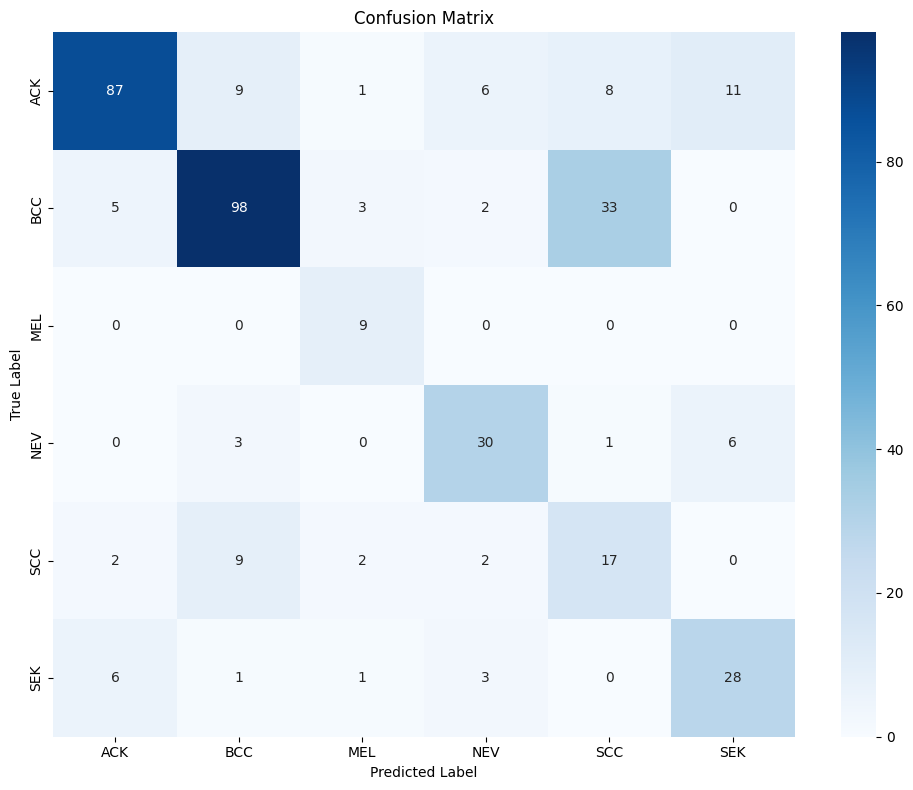

In [ ]:
# Ensure labels are integers
val_preds = [int(p) for p in val_preds]
val_labels = [int(l) for l in val_labels]

# Classification report
report = classification_report(val_labels, val_preds, target_names=class_names)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()